# With Pytorch

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

RANDOM_STATE= 8

## Create Dataset

In [132]:
np.random.seed(RANDOM_STATE)

# create xor dataset
# xor = 0 if x0 * x1 < 0 else 1

X= np.random.uniform(-1, 1, size= (1000, 2))
y= np.where(X[:, 0] * X[:, 1] < 0, 0, 1)

print(X.shape, y.shape)

# create train and test set
X_train, X_val, y_train, y_val= train_test_split(
    X, y, test_size= 0.2, random_state= RANDOM_STATE, 
    shuffle= True, stratify= y
)

print(X_train.shape, y_train.shape)

# check the label distribution
print(np.bincount(y_train), np.bincount(y_val))

(1000, 2) (1000,)
(800, 2) (800,)
[394 406] [ 99 101]


## Build Model

In [133]:
n_features= X_train.shape[1]
n_hidden_neuron= 4
n_output= 1 # binary clf

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        l1= nn.Linear(n_features, n_hidden_neuron)
        a1= nn.ReLU()
        l2= nn.Linear(n_hidden_neuron, n_hidden_neuron)
        a2= nn.ReLU()
        l3= nn.Linear(n_hidden_neuron, n_output)
        a3= nn.Sigmoid()
        self.module_list= nn.ModuleList([
            l1, a1, l2, a2, l3, a3
        ])

    def forward(self, X):
        for f in self.module_list:
            X= f(X)
        return X
    
    def predict(self, X):
        X= torch.tensor(X, dtype= torch.float32)
        self.y_pred_proba= self.forward(X)[:, 0]
        y_pred= self.y_pred_proba.round().float().detach()
        return y_pred

In [134]:
def train(model, loss_fn, optimizer, num_epochs, train_dl):
    
    loss_hist= [0] * num_epochs
    acc_hist= [0] * num_epochs
    num_samples_per_batch= train_dl.batch_size
    num_batch= len(train_dl)
    num_train_samples= num_batch * num_samples_per_batch

    for epoch in range(num_epochs):

        for X_batch, y_batch in train_dl:

            # run forward pass
            # flatten the output
            y_pred_proba= model(X_batch)[:, 0]
            y_pred= y_pred_proba.round().float().detach()

            # calculate and barkpropagate loss
            loss= loss_fn(y_pred_proba, y_batch)
            loss.backward()
            
            # update params
            # reset gradients
            optimizer.step()
            optimizer.zero_grad()

            # get loss, multiply by num samples per batch
            loss_hist[epoch] += loss.item() * num_samples_per_batch

            # get acc, sum to find number of correct pred 
            correct_pred= (y_pred == y_batch).float().sum()
            acc_hist[epoch] += correct_pred

        loss_hist[epoch] /= num_train_samples
        acc_hist[epoch] /= num_train_samples
    
    return loss_hist, acc_hist

## Training

In [135]:
torch.manual_seed(RANDOM_STATE)

X_train_tensor= torch.from_numpy(X_train).float()
y_train_tensor= torch.from_numpy(y_train).float()

train_ds= TensorDataset(X_train_tensor, y_train_tensor)
train_dl= DataLoader(train_ds, batch_size= 10)

lr= 0.001
num_epochs= 100
model= Model()
loss_fn= nn.BCELoss()
optimizer= torch.optim.Adam(model.parameters(), lr= lr)

loss_hist, acc_hist= train(model= model, 
                           loss_fn= loss_fn, 
                           optimizer= optimizer, 
                           num_epochs= num_epochs, 
                           train_dl= train_dl)

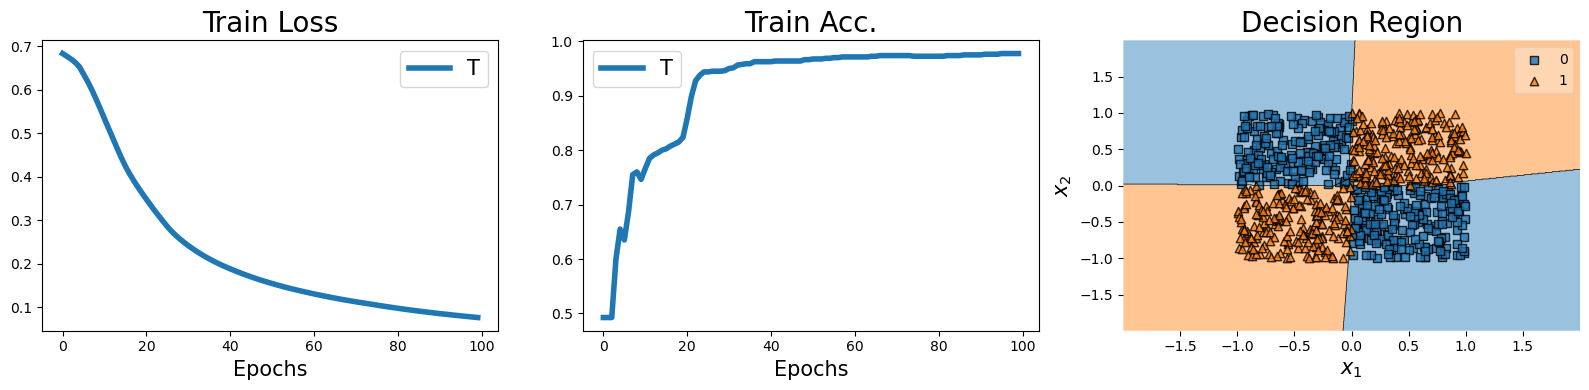

In [136]:
fig = plt.figure(figsize=(16, 4))

# loss
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist, lw=4)
ax.set_title('Train Loss', fontsize= 20)
plt.legend('Train loss', fontsize=15)
ax.set_xlabel('Epochs', size=15)

# accuracy
ax = fig.add_subplot(1, 3, 2)
plt.plot(acc_hist, lw=4)
ax.set_title('Train Acc.', fontsize= 20)
plt.legend('Train acc.', fontsize=15)
ax.set_xlabel('Epochs', size=15)

# decision region
ax = fig.add_subplot(1, 3, 3)
X_val= X_train_tensor.numpy()
y_val= y_train_tensor.numpy().astype(np.int32)
plot_decision_regions(X= X_val,
                      y= y_val,
                      clf= model)
ax.set_title('Decision Region', fontsize= 20)
ax.set_xlabel(r'$x_1$', size=15)
ax.set_ylabel(r'$x_2$', size=15)

plt.tight_layout()
plt.show()

## Training with Validation

In [150]:
def train_val(model, loss_fn, optimizer, num_epochs, train_dl, X_val, y_val):
    
    train_loss_hist= [0] * num_epochs
    train_acc_hist= [0] * num_epochs
    num_samples_per_batch= train_dl.batch_size
    num_batch= len(train_dl)
    num_train_samples= num_batch * num_samples_per_batch
    
    # history for validation set
    val_loss_hist= [0] * num_epochs
    val_acc_hist= [0] * num_epochs

    for epoch in range(num_epochs):

        # training
        for X_batch, y_batch in train_dl:

            # run forward pass
            # flatten the output
            y_pred_proba= model(X_batch)[:, 0]
            y_pred= y_pred_proba.round().float().detach()

            # calculate and barkpropagate loss
            loss= loss_fn(y_pred_proba, y_batch)
            loss.backward()
            
            # update params
            # reset gradients
            optimizer.step()
            optimizer.zero_grad()

            # get loss, multiply by num samples per batch
            train_loss_hist[epoch] += loss.item() * num_samples_per_batch

            # get acc, sum to find number of correct pred 
            correct_pred= (y_pred == y_batch).float().sum()
            train_acc_hist[epoch] += correct_pred

        train_loss_hist[epoch] /= num_train_samples
        train_acc_hist[epoch] /= num_train_samples

        # validation
        y_val_tensor= torch.from_numpy(y_val).float()
        y_pred= model.predict(X_val)
        y_pred_proba= model.y_pred_proba
        correct_pred= (y_pred == y_val_tensor).float()
        # get loss
        loss= loss_fn(y_pred_proba, y_val_tensor)
        val_loss_hist[epoch] = loss.detach()
        # get acc
        acc= correct_pred.mean()
        val_acc_hist[epoch] = acc.detach()
    
    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist
    # return y_pred, y_val

In [163]:
torch.manual_seed(RANDOM_STATE)

X_train_tensor= torch.from_numpy(X_train).float()
y_train_tensor= torch.from_numpy(y_train).float()

train_ds= TensorDataset(X_train_tensor, y_train_tensor)
train_dl= DataLoader(train_ds, batch_size= 10)

lr= 0.001
num_epochs= 50
model= Model()
loss_fn= nn.BCELoss()
optimizer= torch.optim.Adam(model.parameters(), lr= lr)

history= train_val(model= model, 
                   loss_fn= loss_fn, 
                   optimizer= optimizer, 
                   num_epochs= num_epochs, 
                   train_dl= train_dl, 
                   X_val= X_val, 
                   y_val= y_val)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist= history

/tmp/ipykernel_13977/2605880358.py:18: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y= y_val.astype(np.integer),


Text(0.5, 0, '$x_1$')

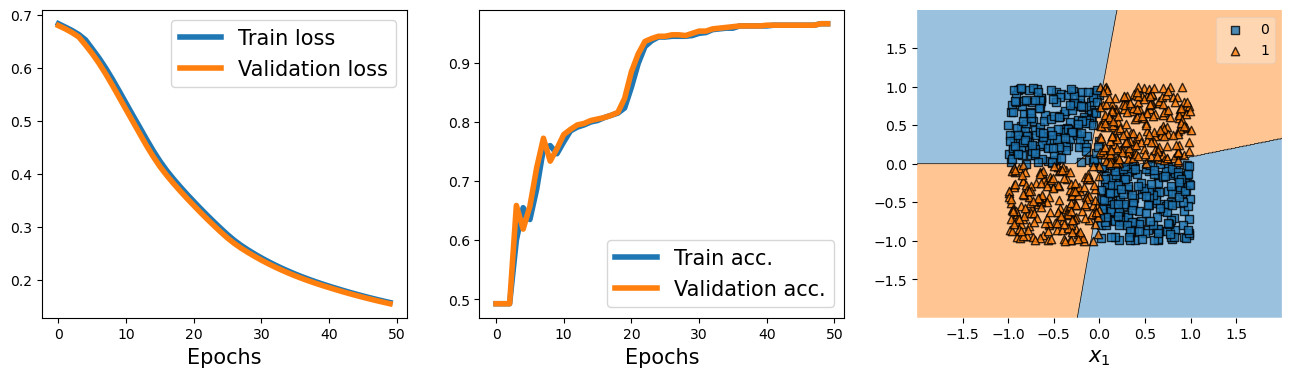

In [164]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(train_loss_hist, lw=4)
plt.plot(val_loss_hist, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(train_acc_hist, lw=4)
plt.plot(val_acc_hist, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

from mlxtend.plotting import plot_decision_regions
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X= X_val,
                      y= y_val.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)

# With TF